In [17]:
# 셀 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d, PchipInterpolator
from tqdm import tqdm

# 한글 폰트 설정 (옵션)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


## 3차 스플라인 보간 + 이동 평균 함수

In [18]:
# 셀 2

def pchip_interpolation(series):
    """
    주어진 시계열 데이터(series)에서 결측치(NaN)를
    PCHIP(형상 보존) 보간법으로 채웁니다.
    
    Parameters:
    - series: pd.Series (인덱스는 시간 혹은 순서)
    
    Returns:
    - 보간된 pd.Series (음수는 0으로 치환)
    """
    # 1) 결측치가 아닌 인덱스와 값 추출
    valid_idx = series.index[series.notna()]
    valid_values = series.dropna().values
    
    # 2) 보간에 사용할 데이터 포인트가 2개 미만이면 보간 불가 → 원본 그대로 반환
    if len(valid_idx) < 2:
        return series
    
    # 3) PCHIP 보간기 생성 (형상 보존)
    pchip = PchipInterpolator(valid_idx, valid_values)
    
    # 4) 전체 인덱스에 대해 보간
    filled_series = series.copy()
    filled_series[:] = pchip(series.index)
    
    # 5) 가격 데이터 음수 방지(음수값을 0으로 치환)
    filled_series[filled_series < 0] = 0
    
    return filled_series

def moving_average(series, window=3):
    """
    주어진 시계열 데이터에 이동 평균(rolling mean)을 적용합니다.
    
    Parameters:
    - series: pd.Series
    - window: int, 이동 평균 창 크기 (기본값: 3)
    
    Returns:
    - 이동 평균이 적용된 pd.Series
    """
    # 중심을 맞추고(center=True), 최소 기간(min_periods=1)을 설정
    return series.rolling(window=window, center=True, min_periods=1).mean()

def fill_missing_data(series, window=3):
    """
    PCHIP 보간(형상 보존) 후 이동 평균을 적용하여 결측치를 보완합니다.
    
    Parameters:
    - series: pd.Series
    - window: int, 이동 평균 창 크기 (기본값: 3)
    
    Returns:
    - 보간 및 평활화된 pd.Series
    """
    # 1) PCHIP 보간
    interpolated = pchip_interpolation(series)
    
    # 2) 이동 평균으로 평활화
    smoothed = moving_average(interpolated, window=window)
    
    # 3) 이동 평균 후에도 혹시 음수 발생 시 0으로 치환
    smoothed[smoothed < 0] = 0
    
    return smoothed

def fill_missing_data_df(df, 
                         time_col='시간', 
                         region_col='동', 
                         item_col='품목', 
                         price_col='가격', 
                         window=3):
    """
    df 내 (동, 품목)별로 시간 순으로 정렬 후,
    '가격' 컬럼에 대해 PCHIP 보간(형상 보존) + 이동평균을 적용하여 결측값을 보완합니다.
    tqdm을 사용해 그룹별 진행 상황을 확인할 수 있습니다.
    
    Parameters:
    - df: 원본 pd.DataFrame (컬럼명: 시간, 동, 품목, 가격)
    - time_col: 시간 컬럼 이름 (기본값: '시간')
    - region_col: 동(지역) 컬럼 이름 (기본값: '동')
    - item_col: 품목 컬럼 이름 (기본값: '품목')
    - price_col: 가격 컬럼 이름 (기본값: '가격')
    - window: 이동 평균 창 크기 (기본값: 3)
    
    Returns:
    - 결측치가 보완된 pd.DataFrame
    """
    # 1) 시간, 동, 품목 순으로 정렬
    df = df.sort_values([region_col, item_col, time_col])
    filled_df = df.copy()
    
    # 2) (동, 품목) 그룹핑
    groups = df.groupby([region_col, item_col])
    
    # 3) tqdm 사용을 위해 전체 그룹 수 계산
    total_groups = len(groups)
    
    # 4) 그룹별 보간
    for (region, item), group in tqdm(groups, total=total_groups, desc="PCHIP+이동평균 보간 진행"):
        # 시간과 가격 시리즈 추출
        times = group[time_col]
        prices = group[price_col]
        
        # 시계열 데이터의 인덱스를 '시간'으로 설정
        series = prices.copy()
        series.index = times
        
        # PCHIP + 이동 평균 적용
        filled_series = fill_missing_data(series, window=window)
        
        # 보간된 결과를 원본 데이터프레임에 반영
        filled_df.loc[group.index, price_col] = filled_series.values
        
    return filled_df


## 파일 입출력 설정 및 결측치 처리 적용 (사용자 인터페이스)

In [19]:
# 셀 3

# (1) 파일 경로 지정 (사용자에 맞게 수정)
input_file = 'C:\\Users\\delta\\Desktop\\대전_물가_IQR_이상치제거.xlsx'
output_file = 'C:\\Users\\delta\\Desktop\\대전_물가_IQR_이상치제거_결측치보완.xlsx'

# (2) 엑셀 파일 읽기 (현재 Wide Format 형태)
df_wide = pd.read_excel(input_file)
# 예: df_wide.columns => ['월', '품목', '조사기준', '가오동', '관평동', '노은2동', ...]

# (3) Wide → Long 변환
df_long = df_wide.melt(
    id_vars=['월','품목'],  
    var_name='동',
    value_name='가격'
)

# (4) "월" 컬럼을 "시간"으로 rename & 시계열 변환
df_long.rename(columns={'월':'시간'}, inplace=True)
df_long['시간'] = pd.to_datetime(df_long['시간'], format='%Y-%m', errors='coerce')
# "2014-10" → "2014-10-01" (임의로 1일자)

# (5) 보완 전 결측치 개수 파악
missing_count_before = df_long['가격'].isna().sum()
print(f"[보완 전] '가격' 결측치 개수: {missing_count_before} 개")

# (6) PCHIP+이동평균 보완
filled_df = fill_missing_data_df(
    df_long, 
    time_col='시간', 
    region_col='동', 
    item_col='품목', 
    price_col='가격', 
    window=3
)

# (7) 보완 후 결측치 개수 파악
missing_count_after = filled_df['가격'].isna().sum()
print(f"[보완 후] '가격' 결측치 개수: {missing_count_after} 개")
print(f"총 {missing_count_before - missing_count_after} 개의 결측치를 보완했습니다.")

# (8) Long 상태 그대로 엑셀 저장 (시계열 분석에 유리)
filled_df.to_excel(output_file, index=False)
print(f"결측치 보완된 Long Format 데이터가 '{output_file}'에 저장되었습니다.")


[보완 전] '가격' 결측치 개수: 16669 개


PCHIP+이동평균 보간 진행: 100%|██████████| 740/740 [00:01<00:00, 662.85it/s]


[보완 후] '가격' 결측치 개수: 122 개
총 16547 개의 결측치를 보완했습니다.
결측치 보완된 Long Format 데이터가 'C:\Users\delta\Desktop\대전_물가_IQR_이상치제거_결측치보완.xlsx'에 저장되었습니다.


## 시각화
품목과 동에 따른 가격 추이 확인

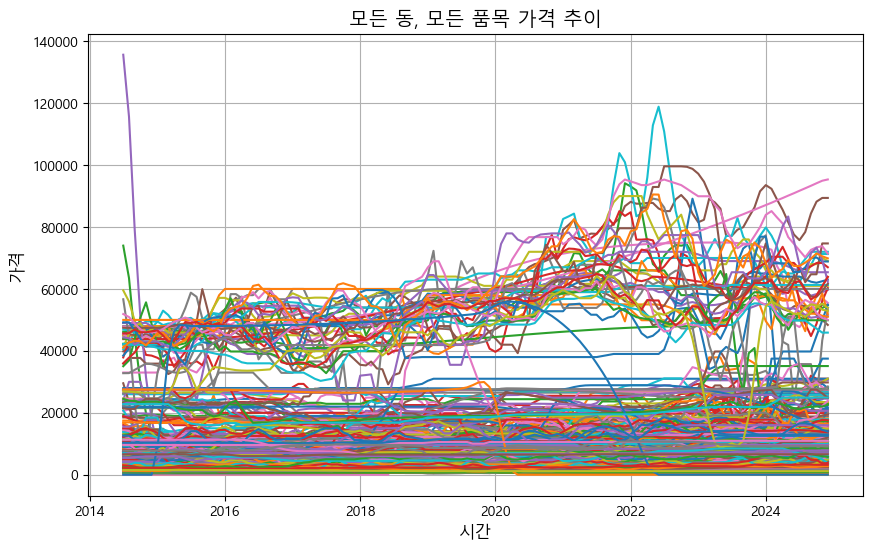

In [20]:
# 셀 4

# (1) 사용자 입력 (동/품목)
#     둘 다 공백("")이면 전체 데이터를 시각화함
selected_region = ''   # 예) '가오동'
selected_item = ''

# 품목 목록 (예시)
item_list = [
    '쌀', '콩', '참깨', '사과', '배', '감귤', '밤', '무', '배추', '고추가루',
    '양파', '대파', '깐마늘', '콩나물', '쇠고기', '돼지고기', '생닭', '달걀', '조기', '동태', 
    '오징어(냉동)', '김', '멸치', '밀가루', '설탕', '두부', '라면', '식용유', '참기름', '분말커피', 
    '소주', '맥주', '청주', '화장지', '빵', '우유', '분유', '세제'
]
# 지역 목록 (예시)
region_list = [
    '가오동', '관평동', '노은2동', '덕암동', '둔산동', 
    '문화동', '비래동', '석봉,목상동', '송촌동', '신성동', 
    '신탄진동', '안영동', '오정동', '온천1동', '온천2동', 
    '용전동', '월평동', '전민동', '진잠동', '회덕동'
]

# (2) 그림 크기 설정
plt.figure(figsize=(10, 6))

# (3) 조건 분기 처리

# 1) 동만 지정 & 품목은 공백
if selected_region and not selected_item:
    data_region = filled_df[filled_df['동'] == selected_region]
    for item_name, group_data in data_region.groupby('품목'):
        group_data = group_data.sort_values(by='시간')
        plt.plot(group_data['시간'], group_data['가격'], label=f"{item_name}")
    plt.title(f"{selected_region} 지역의 모든 품목 가격 추이", fontsize=14)

# 2) 품목만 지정 & 동은 공백
elif not selected_region and selected_item:
    data_item = filled_df[filled_df['품목'] == selected_item]
    for region_name, group_data in data_item.groupby('동'):
        group_data = group_data.sort_values(by='시간')
        plt.plot(group_data['시간'], group_data['가격'], label=f"{region_name}")
    plt.title(f"{selected_item} 품목의 모든 동 가격 추이", fontsize=14)

# 3) 동과 품목 둘 다 지정
elif selected_region and selected_item:
    plot_data = filled_df[
        (filled_df['동'] == selected_region) & 
        (filled_df['품목'] == selected_item)
    ]
    plot_data = plot_data.sort_values(by='시간')
    plt.plot(plot_data['시간'], plot_data['가격'], label=f"{selected_region} - {selected_item}")
    plt.title(f"[{selected_region} - {selected_item}] 가격 추이", fontsize=14)

# 4) 둘 다 미지정
else:
    # 전체 데이터를 (동, 품목) 그룹별로 모두 그리기
    for (region_name, item_name), group_data in filled_df.groupby(['동', '품목']):
        group_data = group_data.sort_values(by='시간')
        plt.plot(group_data['시간'], group_data['가격'], label=f"{region_name}-{item_name}")
    plt.title("모든 동, 모든 품목 가격 추이", fontsize=14)

# (4) 공통 설정: 축 레이블, 범례, 격자
plt.xlabel('시간', fontsize=12)
plt.ylabel('가격', fontsize=12)
plt.grid(True)
plt.show()
